In [104]:
from configobj import ConfigObj
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator
import pyccl as ccl
from pyDOE2 import *
import matplotlib

#from HiCOLA import Frontend

# Get Latin Hypercube

In [2]:
def wr_funct(T_CMB):
    return 4.48150052e-7*T_CMB**4 *(1+ 3.044*7/8 * (4/11)**(4/3))

T_CMB = 2.72548 # K
print(wr_funct(T_CMB))

4.182345109176885e-05


## Get design

In [8]:
# We have Omega_m , n_s    , A_s ,h,  f_phi
sample = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker').T

print(sample.shape)

(5, 50)


In [81]:
n_val_sim = 25
Omg_m_new = np.ones(n_val_sim)*0.321
n_s_new = np.ones(n_val_sim)*0.9626
A_s_new = np.ones(n_val_sim)*2.092e-9
h_new = np.ones(n_val_sim)*0.6688
f_phi_new = np.linspace(0.01 + 0.98/49, 0.99 , n_val_sim)

sample_new = np.array([Omg_m_new, n_s_new, A_s_new, h_new, f_phi_new])
print(sample_new.shape)

(5, 25)


Text(0.5, 0, '$f_{\\phi}$')

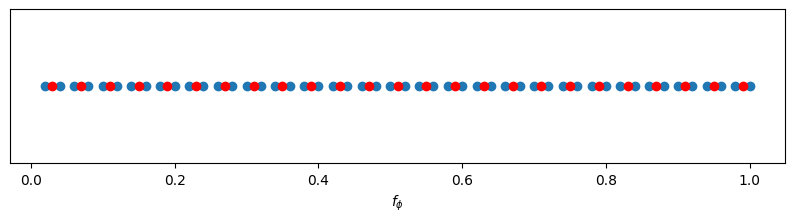

In [82]:
fig, ax = plt.subplots(1,1, sharex = True, sharey=True)
fig.set_size_inches(10,2)

ax.scatter((sample[4]), np.ones(len(sample[4])))

ax.scatter((f_phi_new),np.ones(len(f_phi_new)), color="r")

ax.axes.get_yaxis().set_ticks([])
ax.set_xlabel(r"$f_{\phi}$")


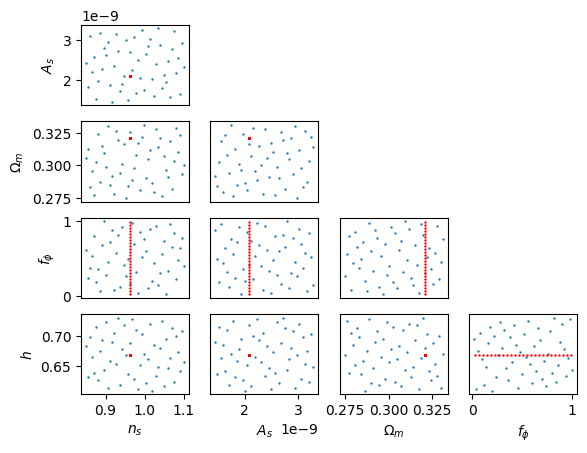

In [86]:
fig, axs = plt.subplots(4, 4)

axs[0, 0].scatter(sample[1], sample[2], s=0.5)
axs[1, 0].scatter(sample[1], sample[0], s=0.5)
axs[2, 0].scatter(sample[1], sample[-1], s=0.5)
axs[3, 0].scatter(sample[1], sample[-2], s=0.5)

axs[1, 1].scatter(sample[2], sample[0], s=0.5)
axs[2, 1].scatter(sample[2], sample[-1], s=0.5)
axs[3, 1].scatter(sample[2], sample[-2], s=0.5)

axs[2, 2].scatter(sample[0], sample[-1], s=0.5)
axs[3, 2].scatter(sample[0], sample[-2], s=0.5)
axs[3, 3].scatter(sample[-1], sample[-2], s=0.5)

axs[0, 0].scatter(sample_new[1], sample_new[2], s=0.5, color="r")
axs[1, 0].scatter(sample_new[1], sample_new[0], s=0.5, color="r")
axs[2, 0].scatter(sample_new[1], sample_new[-1], s=0.5, color="r")
axs[3, 0].scatter(sample_new[1], sample_new[-2], s=0.5, color="r")

axs[1, 1].scatter(sample_new[2], sample_new[0], s=0.5, color="r")
axs[2, 1].scatter(sample_new[2], sample_new[-1], s=0.5, color="r")
axs[3, 1].scatter(sample_new[2], sample_new[-2], s=0.5, color="r")

axs[2, 2].scatter(sample_new[0], sample_new[-1], s=0.5, color="r")
axs[3, 2].scatter(sample_new[0], sample_new[-2], s=0.5, color="r")
axs[3, 3].scatter(sample_new[-1], sample_new[-2], s=0.5, color="r")

# Remove top corner
axs[2, 3].set_axis_off()
axs[1, 3].set_axis_off()
axs[0, 3].set_axis_off()
axs[1, 2].set_axis_off()
axs[0, 2].set_axis_off()
axs[0, 1].set_axis_off()
# Remove excess axes
axs[0, 0].get_xaxis().set_visible(False)
axs[1, 0].get_xaxis().set_visible(False)
axs[1, 1].get_xaxis().set_visible(False)
axs[2, 0].get_xaxis().set_visible(False)
axs[2, 1].get_xaxis().set_visible(False)
axs[2, 2].get_xaxis().set_visible(False)
axs[1, 1].get_yaxis().set_visible(False)
axs[2, 1].get_yaxis().set_visible(False)
axs[3, 1].get_yaxis().set_visible(False)
axs[2, 2].get_yaxis().set_visible(False)
axs[3, 2].get_yaxis().set_visible(False)
axs[3, 3].get_yaxis().set_visible(False)

axs[0, 0].set_ylabel(r"$A_{s}$")
axs[1, 0].set_ylabel(r"$\Omega_{m}$")
axs[2, 0].set_ylabel(r"$f_{\phi}$")
axs[3, 0].set_ylabel(r"$h$")
axs[3, 0].set_xlabel(r"$n_s$")
axs[3, 1].set_xlabel(r"$A_{s}$")
axs[3, 2].set_xlabel(r"$\Omega_{m}$")
axs[3, 3].set_xlabel(r"$f_{\phi}$")

plt.show()
# 0.223 < Omg_m < 0.364
# 0.953 < n_s < 1.063
# 2.03 < 10^9 * A_s < 2.204     # from planck paper only - because of tension 3 sigma
# 0.0465 < Omg_b < 0.0566
# 0.631 < h < 0.721


In [89]:
print(np.max(sample[2]))
print(np.min(sample[2]))

3.291e-09
1.453e-09


### Saving the chosen sampling strategy

In [91]:
# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi

np.savetxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_validation', sample_new.T)



# Run Backend

## Get Power Spectra

In [39]:
## Power spectrum from CCL - backscaling

Pk_ccl = np.zeros((len(sample_new[0]),500))

## Linear Power spectra
wb = 0.0223
wr = wr_funct(T_CMB)

ns = sample_new[1]
As = sample_new[2]
h = sample_new[3]
wm = sample_new[0]*h**2

kk_ccl = np.logspace(-3,1,len(Pk_ccl[0]))*h[0]               # in 1/Mpc
cosmoLCDM = ccl.Cosmology(Omega_c=(wm[0] - wb)/h[0]**2,
                           Omega_b=wb/h[0]**2, 
                           A_s=As[0], 
                           h = h[0],
                           n_s=ns[0],
                           Omega_k=0)

# Omega_g::: Note that if a non-None value is given, this may result in a physically 
# inconsistent model because the CMB temperature will still be non-zero in the parameters.
cosmoLCDM_norad = ccl.Cosmology(Omega_c=(wm[0] - wb)/h[0]**2,
                           Omega_b=wb/h[0]**2, 
                           A_s=As[0], 
                           h = h[0],
                           n_s=ns[0],
                           Omega_k=0,
                           Omega_g = 0,
                           T_CMB = 0.0)

Pk_0 = ccl.power.linear_matter_power(cosmoLCDM, kk_ccl, 1)    # in (Mpc)^3

Growth_0 = ccl.background.growth_factor(cosmoLCDM_norad, 1)

Growth_49 = ccl.background.growth_factor(cosmoLCDM_norad, 1/(1+49))

Pk_ccl = (Growth_49/Growth_0)**2 * Pk_0*h[0]**3    # in (Mpc)^3/h^3

kk_ccl = kk_ccl/h[0]    # in h/Mpc
## Save power spectrum for initial conditions (Linear)
np.savetxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z_validation/Pk_lin_z49_LCDM_backscaled_val.dat", np.array([kk_ccl, Pk_ccl]).T)

kk_ccl = np.logspace(-3,1,500)

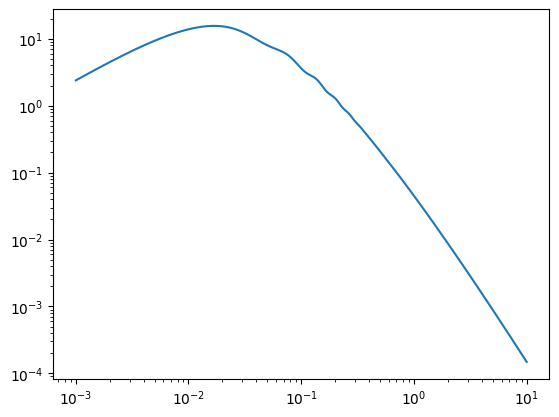

In [40]:
## Plot power spectra (at z = 49, expect very different from z=0)

plt.plot(kk_ccl,Pk_ccl)

plt.xscale("log")
plt.yscale("log")

## Get expansion and force files

In [41]:
"""Define tracker functions"""

# If we are on the tracker, we will get the following constraints equations

# For today formalism 
def k_1T(Omg_m, Omg_r, f_phi):
    return 6*f_phi*(Omg_m + Omg_r - 1)

# dS formalism

def E_dS(Omg_m, Omg_r, f_phi):

    return np.sqrt((1-f_phi)*(1-Omg_m-Omg_r)/2 + np.sqrt(
        ((1-f_phi)*(1-Omg_m-Omg_r)/2)**2 + f_phi*(1-Omg_m-Omg_r)
    ))

In [43]:
''' Define useful functions'''

def hypercube_arrays(txt):
    """
    Takes in txt file with (omega_m,n_s,A_s,h,f_phi)
    returns two arrays, one for numerical and one for horndeski array
    # numerical - [h , wr , wb , wc, n_s , A_s]
    # horndeski - [f_phi, H0, k_1, g_31]
    """
    hcube = np.loadtxt(txt).T

    wb = 0.0223*np.ones(len(hcube[0]))
    wr = wr_funct(T_CMB)*np.ones(len(hcube[0]))
    
    n_s = hcube[1]
    A_s = hcube[2]
    h = hcube[3]
    wm = hcube[0]*h**2


    arr_num = [h, wr, wb, wm - wb, n_s, A_s]
    
    return arr_num

def Update_ini(run, f_phi, arr_num, horn_ini, num_ini):
    """
    Updates files num_ini and horn_ini to include the parameters (numerical and MG) from 
    f_phi and
    arr_num = h , wr , wb , wc, n_s , A_s
    """
    ## Horndeski params
    h , wr , wb , wc, n_s , A_s = arr_num
    config_h = ConfigObj(horn_ini)
    
    k1_track = k_1T((wc + wb)/h**2, wr/h**2, f_phi)

    keys_h = config_h.keys()
    
    config_h[keys_h[1]] = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation'
    config_h[keys_h[0]] = 'horndeski_model'
    
    config_h[keys_h[2]] = 'k_1*X'
    config_h[keys_h[3]] = 'g_31*X'
    config_h[keys_h[4]] = '0.5'

    config_h[keys_h[7]] = str(k1_track)
    config_h[keys_h[8]] = str("1")
    config_h[keys_h[9]] = str(f_phi)
    config_h[keys_h[10]] = str("1")
    config_h[keys_h[11]] = str("1")
    config_h[keys_h[20]] = str("False")
    config_h[keys_h[22]] = str("1")
    
    ## Numerical params
    config_n = ConfigObj(num_ini)
    keys_n = config_n.keys()
    
    config_n[keys_n[0]] = 'run_'+str(run)

    
    config_n[keys_n[6]] = str(h)
    config_n[keys_n[7]] = str(wr)
    config_n[keys_n[8]] = str(wb)
    config_n[keys_n[9]] = str(wc)
    config_h.filename = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini'
    config_n.filename = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'
    config_h.write(); config_n.write()

In [92]:
"""!!!!! CAREFUL WHEN RUNNING THIS deletes a whole directory of frontend parameter files"""
### Run frontend for all different .ini files


txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_validation'

a_n = hypercube_arrays(txt)
for i in range(len(np.array(a_n).T)):
    Update_ini(str(i), np.loadtxt(txt).T[-1][i], np.array(a_n).T[i], '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_parameters.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_parameters.ini')
    command = 'cd ; cd /home/c2042999/HiCOLA_env/Hi-COLA; python3 -m HiCOLA.Frontend.generate_simulation_input /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'
    os.system(command)
    

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.12220316939055371, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.6585393017157618
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.04073438979685107
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.2851407285779587, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.6313830418511943
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.09504690952598616
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.4480782877653637, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.6042267819866268
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.14935942925512113
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.6110158469527686, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.5770705221220593
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.2036719489842561
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.7739534061401736, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.5499142622574918
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.2579844687133912
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.9368909653275787, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.5227580023929244
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.3122969884425263
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-1.0998285245149835, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.4956017425283568
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.3666095081716615
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-1.2627660837023886, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.4684454826637893
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.4209220279007963
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-1.4257036428897931, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.44128922279922184
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.4752345476299314
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-1.5886412020771983, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.41413296293465435
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.5295470673590665
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-1.7515787612646034, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.3869767030700868
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.5838595870882017
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-1.9145163204520081, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.35982044320551937
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.6381721068173365
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-2.077453879639413, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.3326641833409518
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.6924846265464718
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-2.2403914388268182, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.30550792347638434
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.7467971462756069
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-2.4033289980142234, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.2783516636118168
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.8011096660047419
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-2.566266557201628, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.25119540374724936
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.855422185733877
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-2.7292041163890333, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.22403914388268184
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.9097347054630118
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-2.8921416755764384, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.1968828840181143
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 0.964047225192147
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-3.055079234763843, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.16972662415354686
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.018359744921282
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-3.2180167939512483, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.14257036428897935
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.072672264650417
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-3.3809543531386534, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.11541410442441181
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.126984784379552
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-3.5438919123260577, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.08825784455984437
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1812973041086872
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-3.706829471513463, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.06110158469527685
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.235609823837822
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-3.869767030700868, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.03394532483070933
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.2899223435669573
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-4.032704589888272, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.321
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.006789064966141881
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.344234863296092
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation


## Plot Backend

Text(0, 0.5, '$coupling^{CuGal}$')

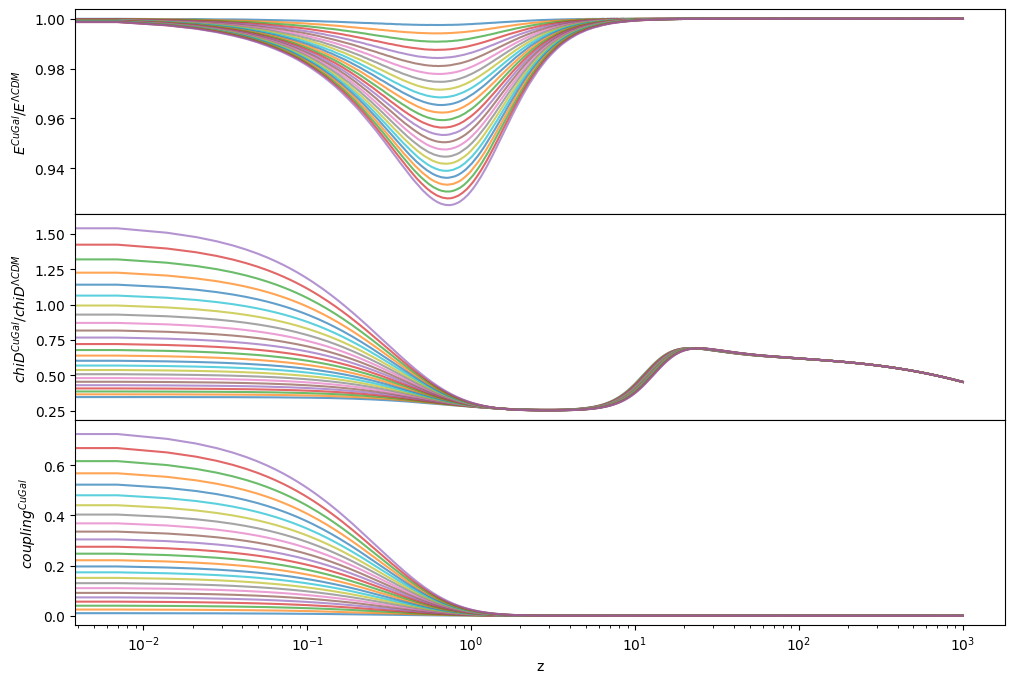

In [93]:
## Plotting ##

a_n = hypercube_arrays(txt)

fig, ax = plt.subplots(3,1, figsize=(12,8),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

sample_new = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_validation').T

# We want Omega_m , n_s    , A_s ,h,  f_phi
for i in range(len(a_n[0])):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation/horndeski_model_run_{}_expansion.txt".format(i))

    wr = wr_funct(T_CMB)
    h = sample_new[3][i]
    wm = sample_new[0][i]*h**2

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    ax[0].plot(1/a_today -1, E_a_today/E_a_GR, alpha=0.7)

    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation/horndeski_model_run_{}_force.txt".format(i))

    a_today = force_today.T[0]
    chiD_today = force_today.T[1]
    coupling = force_today.T[2]

    ax[1].plot(1/a_today -1, chiD_today, alpha=0.7)

    ax[2].plot(1/a_today -1, coupling, alpha=0.7)

ax[0].set_xscale("log")
ax[2].set_xlabel("z")
ax[0].set_ylabel(r"$E^{CuGal}/E^{\Lambda CDM}$")

ax[1].set_ylabel(r"$chiD^{CuGal}/chiD^{\Lambda CDM}$")
ax[2].set_ylabel(r"$coupling^{CuGal}$")



23
24


(0.005, 1000.0)

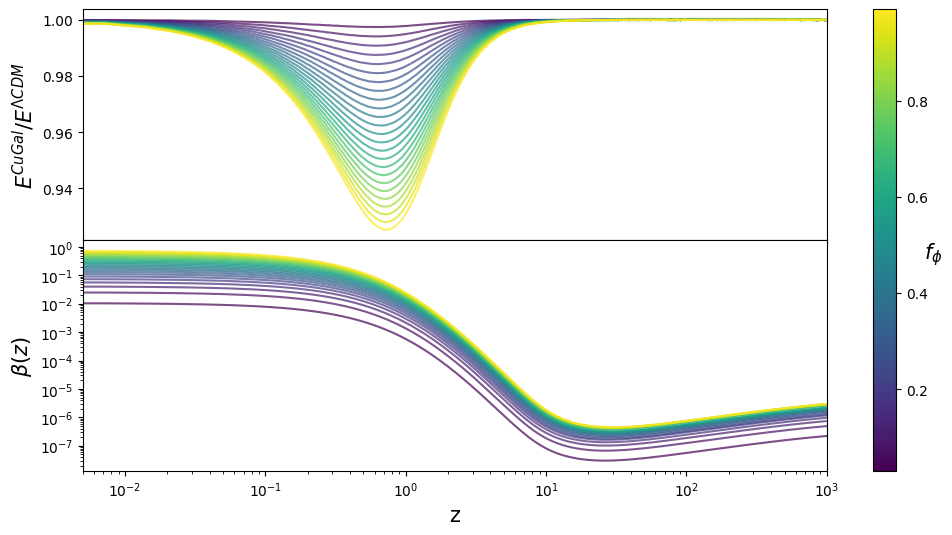

In [95]:
## Plotting ##

cmap = matplotlib.colormaps['viridis']

a_n = hypercube_arrays(txt)

fig, ax = plt.subplots(2,1, figsize=(12,6),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)


theta = sample_new[-1]
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)


# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
for i in range(len(a_n[0])):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation/horndeski_model_run_{}_expansion.txt".format(i))

    wr = wr_funct(T_CMB)
    h = sample_new[3][i]
    wm = sample_new[0][i]*h**2

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    ax[0].plot(1/a_today -1, E_a_today/E_a_GR, alpha=0.7, color = cmap(frac0[i]))

    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation/horndeski_model_run_{}_force.txt".format(i))

    a_today = force_today.T[0]
    chiD_today = force_today.T[1]
    coupling = force_today.T[2]


    ax[1].semilogy(1/a_today -1, coupling, alpha=0.7, color = cmap(frac0[i]))

ax[0].set_xscale("log")
ax[1].set_xlabel("z", fontsize=15)
ax[0].set_ylabel(r"$E^{CuGal}/E^{\Lambda CDM}$", fontsize=15)

ax[1].set_ylabel(r"$\beta(z)$", fontsize=15)
ax[1].set_xlim(5e-3,1e3)

#plt.savefig('/home/c2042999/PCA_project/HiCOLA_frontend.pdf' , bbox_inches='tight')


# Run Frontend

In [97]:
# Create cola folders - only need to do this once

for i in range(len(np.array(a_n).T)):
    # CAREFUL!! might not need this next step
    #command = 'cd; rm -r /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_tracker'.format(str(i))
    #os.system(command)
    os.system("cd; cd /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/; mkdir COLA_{}_tracker".format(str(i)))
    #command = 'cd; rm -r /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_GR_tracker'.format(str(i))
    #os.system(command)
    os.system("cd; cd /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/; mkdir COLA_{}_GR_tracker".format(str(i)))


In [98]:
def rewriteluafile(k,txt,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,h,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """

    wb = 0.0223
    wr = wr_funct(T_CMB)
    
    hcube = np.loadtxt(txt).T
    n_s = hcube[1][k]
    A_s = hcube[2][k]
    h = hcube[3][k]
    wm = hcube[0][k]*h**2

    f_phi = hcube[4][k]
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = wm/h**2
    Omg_b = wb/h**2
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles_validation/Hi-COLA_params_emu_{}_tracker.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_{}_tracker"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 50:
            c.write('cosmology_TCMB_kelvin = '+str(T_CMB)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation/horndeski_model_run_{}_expansion.txt"'.format(str(k))+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation/horndeski_model_run_{}_force.txt"'.format(str(k))+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_tracker"'.format(str(k))+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {100}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(108)+'\n')
        elif i== 251:
            c.write('ic_fix_amplitude = true'+'\n')
        elif i== 253:
            c.write('ic_reverse_phases = false'+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z_validation/Pk_lin_z49_LCDM_backscaled_val.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()



In [101]:
def rewriteluafile_phasepair(k,txt,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """

    wb = 0.0223
    wr = wr_funct(T_CMB)
    
    hcube = np.loadtxt(txt).T
    n_s = hcube[1][k]
    A_s = hcube[2][k]
    h = hcube[3][k]
    wm = hcube[0][k]*h**2

    f_phi = hcube[4][k]
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = wm/h**2
    Omg_b = wb/h**2
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles_validation/Hi-COLA_params_emu_{}_tracker_phasepair.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_{}_tracker_phasepair"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 50:
            c.write('cosmology_TCMB_kelvin = '+str(T_CMB)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation/horndeski_model_run_{}_expansion.txt"'.format(str(k))+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation/horndeski_model_run_{}_force.txt"'.format(str(k))+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(3.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_tracker"'.format(str(k))+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {100}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(108)+'\n')
        elif i== 251:
            c.write('ic_fix_amplitude = true'+'\n')
        elif i== 253:
            c.write('ic_reverse_phases = true'+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z_validation/Pk_lin_z49_LCDM_backscaled_val.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()


In [100]:
"""Re-write lua file"""
for i in range(len(np.array(a_n).T)):
    rewriteluafile(i,txt,400,512,1536)
    # phase pair
    rewriteluafile_phasepair(i,txt,400,512,1536)


In [ ]:
"""Create Pk"""
for i in range(len(np.array(a_n).T)):
    os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles_validation/Hi-COLA_params_emu_{}_tracker.lua".format(str(i)))
    


#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 80 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-7]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-7]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-7]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-7]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-7]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-7]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-7]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

In [ ]:
"""Create Pk phasepair"""
for i in range(len(np.array(a_n).T)):
    os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles_validation/Hi-COLA_params_emu_{}_tracker_phasepair.lua".format(str(i)))
    


#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 80 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-7]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-7]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-7]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-7]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-7]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-7]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-7]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

# Results

In [59]:
"Check phase pair"

k, Pk_NL_phase,Pk_Lin_phase = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0_tracker/pofk_my_new_Hi-COLA_simulation_0_tracker_phasepair_cb_z0.000.txt").T
k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0_tracker/pofk_my_new_Hi-COLA_simulation_0_tracker_cb_z0.000.txt").T





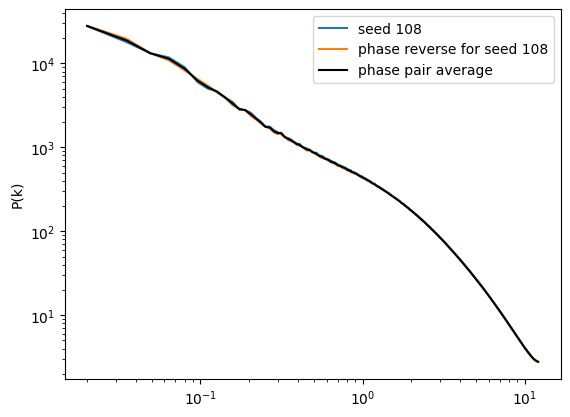

In [61]:

plt.plot(k,Pk_NL, label = "seed 108")
plt.plot(k, Pk_NL_phase, label="phase reverse for seed 108")

plt.plot(k,(Pk_NL_phase + Pk_NL)/2, "k", label = "phase pair average")

plt.xscale("log")
plt.yscale("log")
plt.ylabel("P(k)")
plt.legend()